In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

/var/folders/7b/trlfgd_d5gv_jv53bccbf7rw0000gn/T/ipykernel_15155/3555078317.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()[0]
most_recent_date

'2017-08-23'

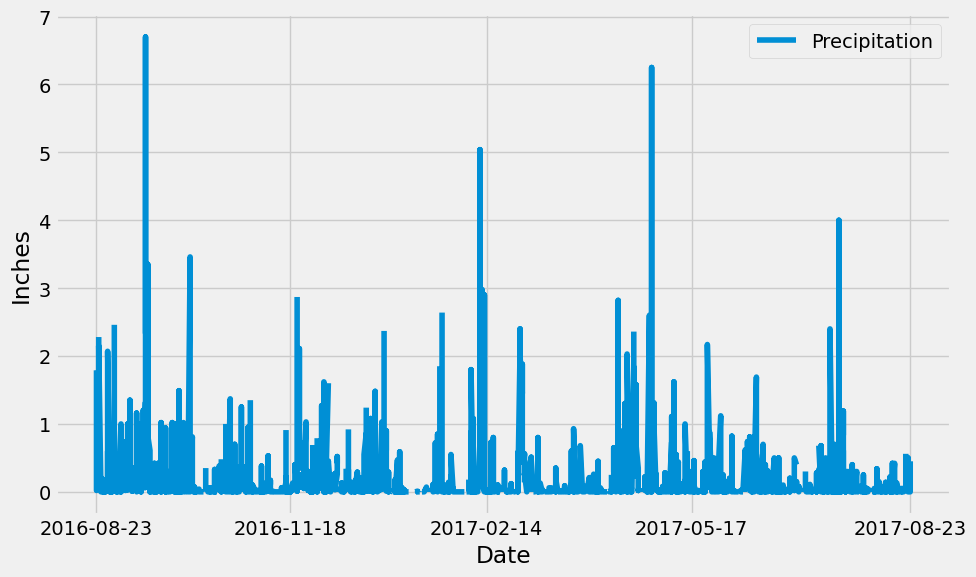

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
key_dates = np.linspace(0, len(precipitation_df) - 1, num=5, dtype=int)
key_date_labels = precipitation_df['Date'].iloc[key_dates]
plt.xticks(key_date_labels, rotation=0) 
plt.legend()  # This will place the legend in a suitable position automatically

# Show the plot
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = (
    session.query(Station.station, func.count(Measurement.station).label('measurement_count'))
    .join(Measurement, Station.station == Measurement.station)
    .group_by(Station.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
for station, measurement_count in results:
    print(f"{station}, {measurement_count}")

USC00519281, 2772
USC00519397, 2724
USC00513117, 2709
USC00519523, 2669
USC00516128, 2612
USC00514830, 2202
USC00511918, 1979
USC00517948, 1372
USC00518838, 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Fetch data from the Measurement table
measurement_data = session.query(Measurement.station, Measurement.tobs).all()

most_active_station = results[0][0]  

filtered_data = [row for row in measurement_data if row[0] == most_active_station]

tobs_values = [row[1] for row in filtered_data]

# Get the most active station from the previous results
most_active_station = results[0][0]

# Filter data for the most active station
filtered_data = [row for row in measurement_data if row[0] == most_active_station]

# Extract temperature values
tobs_values = [row[1] for row in filtered_data]

# Calculate and print temperature statistics
if tobs_values:
    lowest_temp = min(tobs_values)
    highest_temp = max(tobs_values)
    avg_temp = sum(tobs_values) / len(tobs_values)

    print(f"Station {most_active_station}")
    print(f"Lowest Temperature: {lowest_temp}")
    print(f"Highest Temperature: {highest_temp}")
    print(f"Average Temperature: {avg_temp}")

Station USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


Text(0.5, 0, 'Temperature')

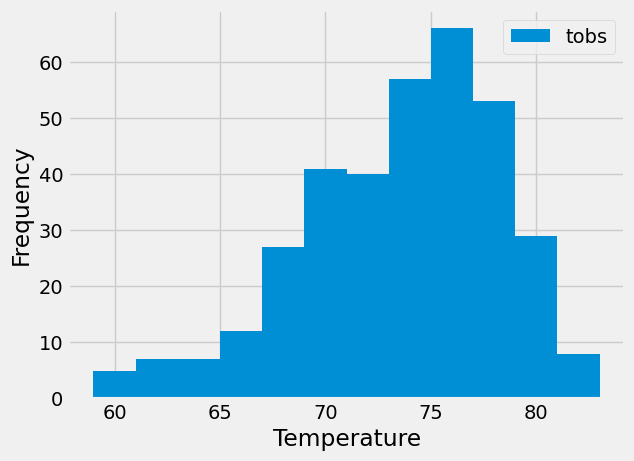

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= one_year_ago).all()

df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.xlabel("Temperature")

# Close Session

In [16]:
# Close Session
session.close()
